In [1]:
import scipy
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## integrate.odeint  la funcion que se va a usar en vez de runge kutta


In [3]:
## 52 kg cm2

$R_x = R_{xf} + R_{xr} = f_r(W_f+W_r) = f_rW\ $

Fuerza de rodadura

$F_b = F_{bf} + F_{br}\ $

Fuerza total del frenado aplicado en las ruedas de adelante (forward) y atrás (rear).

In [4]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=5.2E-3 # Inercia motor de combustión (kg m^2) 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

#paso=7.62 #(mm)
#rpim= paso*(0.6+(1/tan(180/dp))) # Radio Piñon (mm)
#rplam=paso*(0.6+(1/tan(180/dpl))) # Radio Plato (mm)
#rpi= rpim/1000 #Radio Piñon (m)
#rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)

masa_eq = 200 # ESto toca calcularlo correctamente

gamma = 1 # aceleracion

In [5]:
def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    # fr=C*((mllt*g)/(rllt*2))*sqrt(ht/bllt)
    # ht=0.0739 # Altura del neumático (m)
    # bllt=0.209 # Ancho del neumático (m)
    # C= # Constante del material de la llanta
    return wr*fr*np.cos(theta) # (N)

In [6]:
def frodadura_const(vx):
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)
    # fr=C*((mllt*g)/(rllt*2))*sqrt(ht/bllt)
    # ht=0.0739 # Altura del neumático (m)
    # bllt=0.209 # Ancho del neumático (m)
    # C= # Constante del material de la llanta
    return w*fr*np.cos(theta) # (N)

In [7]:
# Fuerza del ángulo de la carretera
def finclinacion(theta):
    return w*np.sin(theta) # (N)

In [8]:
# Fuerza de arrastre
def farrastre(vx):
    return (1.0/2.0)*rho*af*cd*(vx+vw)**2 # (N)

In [9]:
# Fuerza de tracción, Torque del Motor
def ftraccion(ax,Fg,Fw,Fr):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masa*ax+Fg+Fw+Fr

In [10]:
def torquemotor(ax,Ft):
    return (Ft+(((ii-ig)/(ng**2))+ieje+illd*2+illt*2)*(ax/(refc**2)))*(refc/(ng*etaf)) # Torque del motor (Nm)

In [11]:
# Velocidad angular del motor
def vangularmotor(vx):
    return (vx*ng)/refc # (rad/s)

In [12]:
def dveldt(velv,t0):
    xx,vel = velv
    omega_llanta = vel/refc
    omega_motor = omega_llanta/ng
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    fincli = finclinacion(theta)
    return [vel,(torquemotor_curva(omega_motor,gamma)*ng*etaf/refc-frod-farr-fincli)/masa_eq] # para solucionar
    # al tiempo posición y velocidad

In [13]:
# Variables de tiempo
t_in=0
t_fin=10
deltat=0.001

# condiciones iniciales
x_0=0
v_0=0
c_ini = [x_0,v_0]
t=np.arange(t_in,t_fin,deltat)

## Modificar abajo


In [14]:
def torquemotor_curva(omega_m,gamma):
    return 35

## Modificar arriba

In [15]:
sol = integrate.odeint(dveldt, c_ini, t)

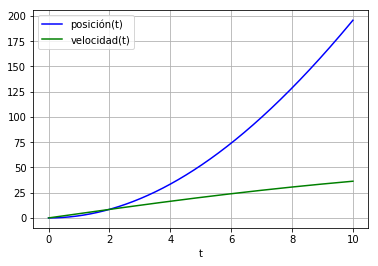

In [16]:
plt.plot(t, sol[:, 0], 'b', label='posición(t)')
plt.plot(t, sol[:, 1], 'g', label='velocidad(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()


In [17]:
def torquemotor_curva(omega_m,gamma):
    
    P=((-0.00000004564538677*omega_m**3)+(0.0001056995459*omega_m**2)+(1.53209191*omega_m)-1.895523696)
    return P


In [18]:
def dveldt_1(velv,t0):
    xx,vel = velv
    omega_llanta = vel/refc
    omega_motor = omega_llanta/ng
    frod = frodadura_const(vel*3.6)
    farr = farrastre(vel)
    fincli = finclinacion(theta)
    return [vel,(torquemotor_curva(omega_motor,gamma)*ng*etaf/refc-frod-farr-fincli)/masa_eq] # para solucionar
    # al tiempo posición y velocidad

In [21]:
sol_1 = integrate.odeint(dveldt_1, c_ini, t)

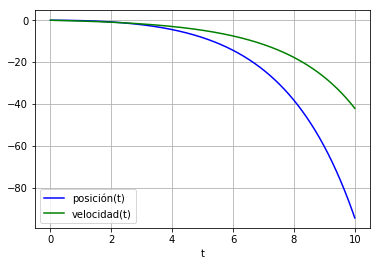

In [22]:
plt.plot(t, sol_1[:, 0], 'b', label='posición(t)')
plt.plot(t, sol_1[:, 1], 'g', label='velocidad(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()